# Klasyfikacja chorób na podstawie objawów

### Wczytanie bibliotek

In [170]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import os

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

import json

import faiss
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

import pickle

from scipy.stats import ks_2samp
from itertools import combinations
from joblib import Parallel, delayed
from tqdm import tqdm
from collections import defaultdict

### Wczytanie danych

In [171]:
diseases_data = pd.read_csv("../Data/Final_Augmented_dataset_Diseases_and_Symptoms.csv")

labels = diseases_data.iloc[:, 0]
data = diseases_data.iloc[:, 1:]

print(diseases_data.shape)
diseases_data.head()

(246945, 378)


,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
0,panic disorder,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,panic disorder,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,panic disorder,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,panic disorder,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,panic disorder,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


### Analiza danych

In [172]:
diseases_data.describe()

,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,palpitations,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
count,246945.000000,246945.000000,246945.000000,246945.000000,246945.000000,246945.000000,246945.000000,246945.000000,246945.000000,246945.000000,...,246945.0,246945.0,246945.0,246945.0,246945.000000,246945.0,246945.0,246945.0,246945.000000,246945.0
mean,0.039235,0.042746,0.086440,0.061001,0.097252,0.069943,0.039410,0.040572,0.037871,0.024876,...,0.0,0.0,0.0,0.0,0.001385,0.0,0.0,0.0,0.000073,0.0
std,0.194155,0.202285,0.281014,0.239333,0.296302,0.255051,0.194568,0.197296,0.190884,0.155747,...,0.0,0.0,0.0,0.0,0.037189,0.0,0.0,0.0,0.008537,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0


In [173]:
print(diseases_data.isna().sum().sum())
diseases_data.isna().any()

0


diseases                            False
anxiety and nervousness             False
depression                          False
shortness of breath                 False
depressive or psychotic symptoms    False
                                    ...  
hip weakness                        False
back swelling                       False
ankle stiffness or tightness        False
ankle weakness                      False
neck weakness                       False
Length: 378, dtype: bool

In [174]:
print(diseases_data.isnull().sum().sum())
diseases_data.isnull().any()

0


diseases                            False
anxiety and nervousness             False
depression                          False
shortness of breath                 False
depressive or psychotic symptoms    False
                                    ...  
hip weakness                        False
back swelling                       False
ankle stiffness or tightness        False
ankle weakness                      False
neck weakness                       False
Length: 378, dtype: bool

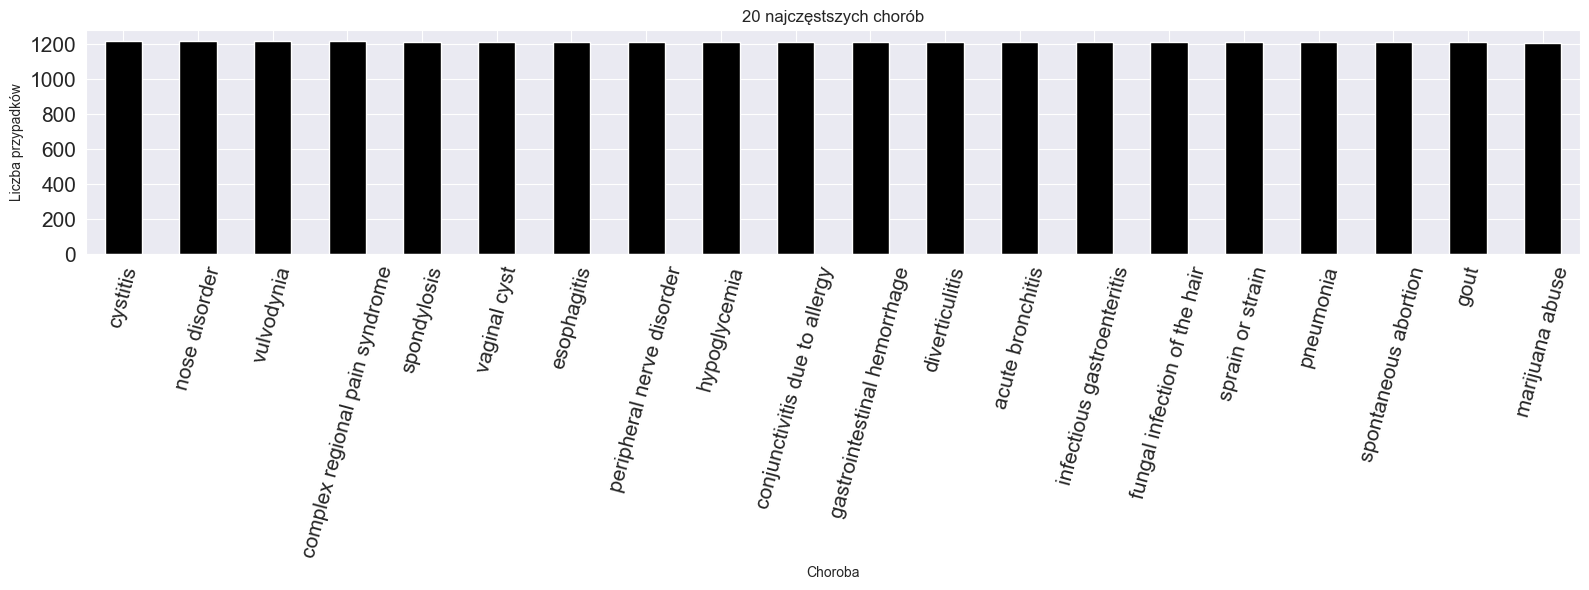

In [175]:
plt.figure(figsize=(16, 6))
labels.value_counts().head(20).plot(kind='bar', color='black', fontsize=15)
plt.title('20 najczęstszych chorób')
plt.xlabel('Choroba')
plt.ylabel('Liczba przypadków')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

### Wyrównanie ilości danych za pomocą SMOT, aby nie wykluczać rzadkich chorób
https://datascience.eu/pl/programowanie-komputerowe/smote/
https://miroslawmamczur.pl/niezbalansowane-dane-klasyfikacyjne-na-ratunek-smote/

In [176]:
# Choroby z jednym wystąpieniem

label_counts = labels.value_counts()

rare_labels = label_counts[label_counts == 1].index

rare_labels

Index(['turner syndrome', 'rocky mountain spotted fever',
       'open wound of the cheek', 'high blood pressure',
       'open wound due to trauma', 'open wound of the chest',
       'huntington disease', 'open wound of the knee',
       'foreign body in the nose', 'diabetes', 'thalassemia', 'heat stroke',
       'gas gangrene', 'typhoid fever', 'open wound of the head',
       'myocarditis', 'chronic ulcer', 'hypergammaglobulinemia',
       'kaposi sarcoma'],
      dtype='object', name='diseases')

In [177]:
# Duplikacja danych do 2 dla rzadkich chorób - SMOTE wymaga min.2

rare_data = data[labels.isin(rare_labels)]
rare_labels_series = labels[labels.isin(rare_labels)]

# Duplikujemy te rekordy
duplicated_data = rare_data.copy()
duplicated_labels = rare_labels_series.copy()

# Scalanie oryginalnych danych z duplikatami
data_augmented = pd.concat([data, duplicated_data], ignore_index=True)
labels_augmented = pd.concat([labels, duplicated_labels], ignore_index=True)

print(f"Liczba rekordów przed SMOTE: {len(labels_augmented)}")

Liczba rekordów przed SMOTE: 246964


In [178]:
smote = SMOTE(k_neighbors=1)
data, labels = smote.fit_resample(data_augmented, labels_augmented)

In [179]:
print(f"Liczba rekordów po SMOTE: {len(labels)}")

Liczba rekordów po SMOTE: 942287


### Usunięcie kolun ze stałą wartością 

In [180]:
# Żaden przypadek choroby w datasecie nie ma tych objawów

constant_cols = [col for col in diseases_data.columns if diseases_data[col].nunique() <= 1]
print("Kolumny o stałej wartości:", constant_cols)

Kolumny o stałej wartości: ['pus in sputum', 'underweight', 'arm cramps or spasms', 'abnormal appearing tongue', 'pallor', 'shoulder cramps or spasms', 'joint stiffness or tightness', 'eye strain', 'pus in urine', 'abnormal size or shape of ear', 'elbow cramps or spasms', 'feeling hot and cold', 'nailbiting', 'hip swelling', 'foot or toe cramps or spasms', 'low back swelling', 'hip lump or mass', 'feet turned in', 'elbow stiffness or tightness', 'mass on ear', 'throat irritation', 'swollen tongue', 'disturbance of smell or taste', 'discharge in stools', 'pupils unequal', 'sleepwalking', 'skin oiliness', 'knee cramps or spasms', 'posture problems', 'bleeding in mouth', 'tongue bleeding', 'change in skin mole size or color', 'polyuria', 'infrequent menstruation', 'mass on vulva', 'jaw pain', 'eyelid retracted', 'elbow lump or mass', 'tongue pain', 'low back stiffness or tightness', 'skin on head or neck looks infected', 'stuttering or stammering', 'problems with orgasm', 'nose deformity'

In [181]:
data = data.loc[:, data.nunique() > 1]
data.shape

(942287, 328)

### Macierz korelacji

In [182]:
# corr_matrix = data.corr()

# plt.figure(figsize=(20, 20))
# sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
# plt.title('Macierz korelacji cech')
# plt.tight_layout()
# plt.show()
# plt.close()

# if not os.path.exists("./Features_corr.svg"):
#     # Zapis jako grafikę wektorową
#     plt.figure(figsize=(100, 100))
#     sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
#     plt.title('Macierz korelacji cech')
#     plt.tight_layout()
#     plt.savefig("Features_corr.svg", format="svg")
#     plt.close()

### Test Kołmogorowa-Smirnowa

In [183]:
ks_file = "ks_results.pkl"

if os.path.exists(ks_file):
    with open(ks_file, "rb") as f:
        pairs, results = pickle.load(f)
else:
    ks_threshold = 0.01  # Maksymalna dopuszczalna wartość statystyki testu KS – im mniejsza, tym bardziej podobne rozkłady
    p_value_threshold = 0.9  # Minimalna wartość p-value, przy której uznajemy, że nie ma istotnej różnicy statystycznej między kolumnami

    cols = data.columns.tolist()
    pairs = list(combinations(cols, 2))  # Wszystkie możliwe unikalne pary kolumn

    def test_similarity(col1, col2):
        stat, p_value = ks_2samp(data[col1], data[col2])  # Oblicza statystykę testu Kołmogorowa dla dwóch rozkładów
        if stat < ks_threshold and p_value > p_value_threshold:
            return col2
        return None
    
    # Obliczenia dla wszystkich par kolumn liczone na wszystkich rdzeniach procesora
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(test_similarity)(c1, c2)
        for c1, c2 in tqdm(pairs, total=len(pairs))
    )

    with open(ks_file, "wb") as f:
        pickle.dump((pairs, results), f)

In [184]:
similar_features = defaultdict(list)

for (col1, col2), result in zip(pairs, results):
    if result:
        similar_features[col1].append(col2)

print("Podobne kolumny:")
for main_feature, similars in similar_features.items():
    print(f"{main_feature}: {', '.join(similars)}")

Podobne kolumny:
anxiety and nervousness: abnormal involuntary movements, nasal congestion, leg pain, abnormal appearing skin, skin lesion, diminished vision, back pain, fever, fatigue
depression: insomnia, abnormal involuntary movements, palpitations, irregular heartbeat, sore throat, difficulty speaking, nasal congestion, skin swelling, suprapubic pain, emotional symptoms, fainting, vaginal itching, painful urination, lower abdominal pain, arm pain, abnormal appearing skin, skin lesion, diminished vision, symptoms of eye, pain in eye, back pain, knee pain, problems with movement, weakness, fatigue
shortness of breath: depressive or psychotic symptoms, sharp chest pain, dizziness, cough, sharp abdominal pain
depressive or psychotic symptoms: sharp chest pain, dizziness, cough, vomiting, nausea
sharp chest pain: dizziness, cough, sharp abdominal pain, vomiting
dizziness: cough, vomiting, nausea
insomnia: chest tightness, palpitations, irregular heartbeat, sore throat, difficulty speaki

### Podział danych

In [185]:
data = data.sample(n=1000, random_state=10)
labels = labels.loc[data.index]

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=10)

### Trenowanie modeli i zapis do plików
https://arithmancylabs.medium.com/understanding-faiss-indexing-86ec98048bd9

In [196]:
# Użyłem modelu KNN z biblioteki faiss (Facebook AI Similarity Search)
# Model KNN z biblioteki scikit-learn jest nie wydajny dla dużej ilości danych
# KNN i drzewa decyzyjne działają na całości danych - nie da się podzielić na mniejsze porcje do stopniowego trenowania modelu

models = {
    "DecisionTree": DecisionTreeClassifier(random_state=10),
    "LogisticRegression": LogisticRegression(random_state=10),
    "KMeans": KMeans(n_clusters=len(set(Y_train)), random_state=10),
    "KNN": "FAISS" 
}

results = {}

faiss_index = None
faiss_labels = None

results_path = "../Models_Files/results.json"

if not os.path.exists("../Models_Files/DecisionTree_model.pkl"):
    for name, model in models.items():
        start_time = time.time()
        
        if name == "KNN":
            dimension = X_train.shape[1]  # Liczba wymiarów danych (cech)
            index = faiss.IndexFlatL2(dimension)  # Indeks FAISS do wyszukiwania sąsiadów przy użyciu metryki L2 (Euklidesowej).
            index.add(np.array(X_train).astype('float32'))  # Dodanie danych treningowych do indexu i przekształcenie na float32 
    
            _, Indexes = index.search(np.array(X_test).astype('float32'), k=3)  # Przeszukuje indeks FAISS w poszukiwaniu 3 najbliższych sąsiadów dla każdego rekordu z X_test
    
            y_pred = []
            for neighbors in Indexes:
                neighbor_labels = Y_train.iloc[neighbors]  # Etykiety (choroby) sąsiadów
                most_common = Counter(neighbor_labels).most_common(1)[0][0]  # 1 najczęściej występująca choroba wśród tych 3 sąsiadów
                y_pred.append(most_common)  
    
            accuracy = accuracy_score(Y_test, y_pred)
            precision = precision_score(Y_test, y_pred, average="weighted", zero_division=0)
            recall = recall_score(Y_test, y_pred, average="weighted", zero_division=0)
    
            results[name] = {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "time": time.time() - start_time
            }
            
            faiss_index = index
            faiss_labels = Y_train.to_numpy()
    
        elif name == "KMeans":
            model.fit(X_train)
            cluster_labels = model.predict(X_test)  # Przewidujemy, do którego klastra należy każdy rekord testowy
    
            cluster_to_label = {}  # Słownik numer klastra -> etykieta
            train_clusters = model.predict(X_train)  # Sprawdzamy, do których klastrów należą dane treningowe
            
            for i in range(model.n_clusters):
                labels_in_cluster = Y_train[train_clusters == i]  # Wybieramy wszystkie etykiety y_train
                
                # Jeżeli są jakieś etykiety w tym klastrze, to bierzemy najczęściej występującą etykietę i przypisujemy ją jako etykietę dla całego klastra
                if len(labels_in_cluster) > 0:
                    cluster_to_label[i] = Counter(labels_in_cluster).most_common(1)[0][0]
                else:
                    cluster_to_label[i] = "unknown"
    
            pred_labels = [cluster_to_label.get(c, "unknown") for c in cluster_labels]  # Dla każdego klastra przypisanego do X_test, zamieniamy numer klastra na nazwę choroby
            
            accuracy = accuracy_score(Y_test, pred_labels)
            precision = precision_score(Y_test, pred_labels, average="weighted", zero_division=0)
            recall = recall_score(Y_test, pred_labels, average="weighted", zero_division=0)
    
            results[name] = {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "time": time.time() - start_time
            }
    
        else:
            model.fit(X_train, Y_train)
            preds = model.predict(X_test)
            
            accuracy = accuracy_score(Y_test, preds)
            precision = precision_score(Y_test, preds, average="weighted", zero_division=0)
            recall = recall_score(Y_test, preds, average="weighted", zero_division=0)
    
            results[name] = {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "time": time.time() - start_time
            }
        
    print("Podsumowanie wyników:")
    for model_name, metrics in results.items():
        print(f"{model_name}: Dokładność: {metrics['accuracy']:.3f}, Czułość: {metrics['recall']:.3f}, Celność: {metrics['precision']:.3f}, \nczas trenowania modelu: {metrics['time']:.3f}s\n")
        
    for name, model in models.items():
        if name == "KNN":
            faiss.write_index(faiss_index, "../Models_Files/KNN_faiss.index")
            np.save("../Models_Files/KNN_labels.npy", faiss_labels)
        else:
            with open(f"../Models_Files/{name}_model.pkl", "wb") as file:
                pickle.dump(model, file)

    with open(results_path, "w") as f:
        json.dump(results, f, indent=4)

else:
    with open(results_path, "r") as f:
        results = json.load(f)

    print("Podsumowanie wyników (wczytane z pliku):")
    for model_name, metrics in results.items():
        print(f"{model_name}: Dokładność: {metrics['accuracy']:.3f}, Czułość: {metrics['recall']:.3f}, Celność: {metrics['precision']:.3f}, \nczas trenowania modelu: {metrics['time']:.3f}s\n")


Podsumowanie wyników (wczytane z pliku):
DecisionTree: Dokładność: 0.260, Czułość: 0.260, Celność: 0.261, 
czas trenowania modelu: 0.105s

LogisticRegression: Dokładność: 0.305, Czułość: 0.305, Celność: 0.257, 
czas trenowania modelu: 0.416s

KMeans: Dokładność: 0.285, Czułość: 0.285, Celność: 0.287, 
czas trenowania modelu: 0.307s

KNN: Dokładność: 0.350, Czułość: 0.350, Celność: 0.326, 
czas trenowania modelu: 0.049s



### Porównanie wyników modeli

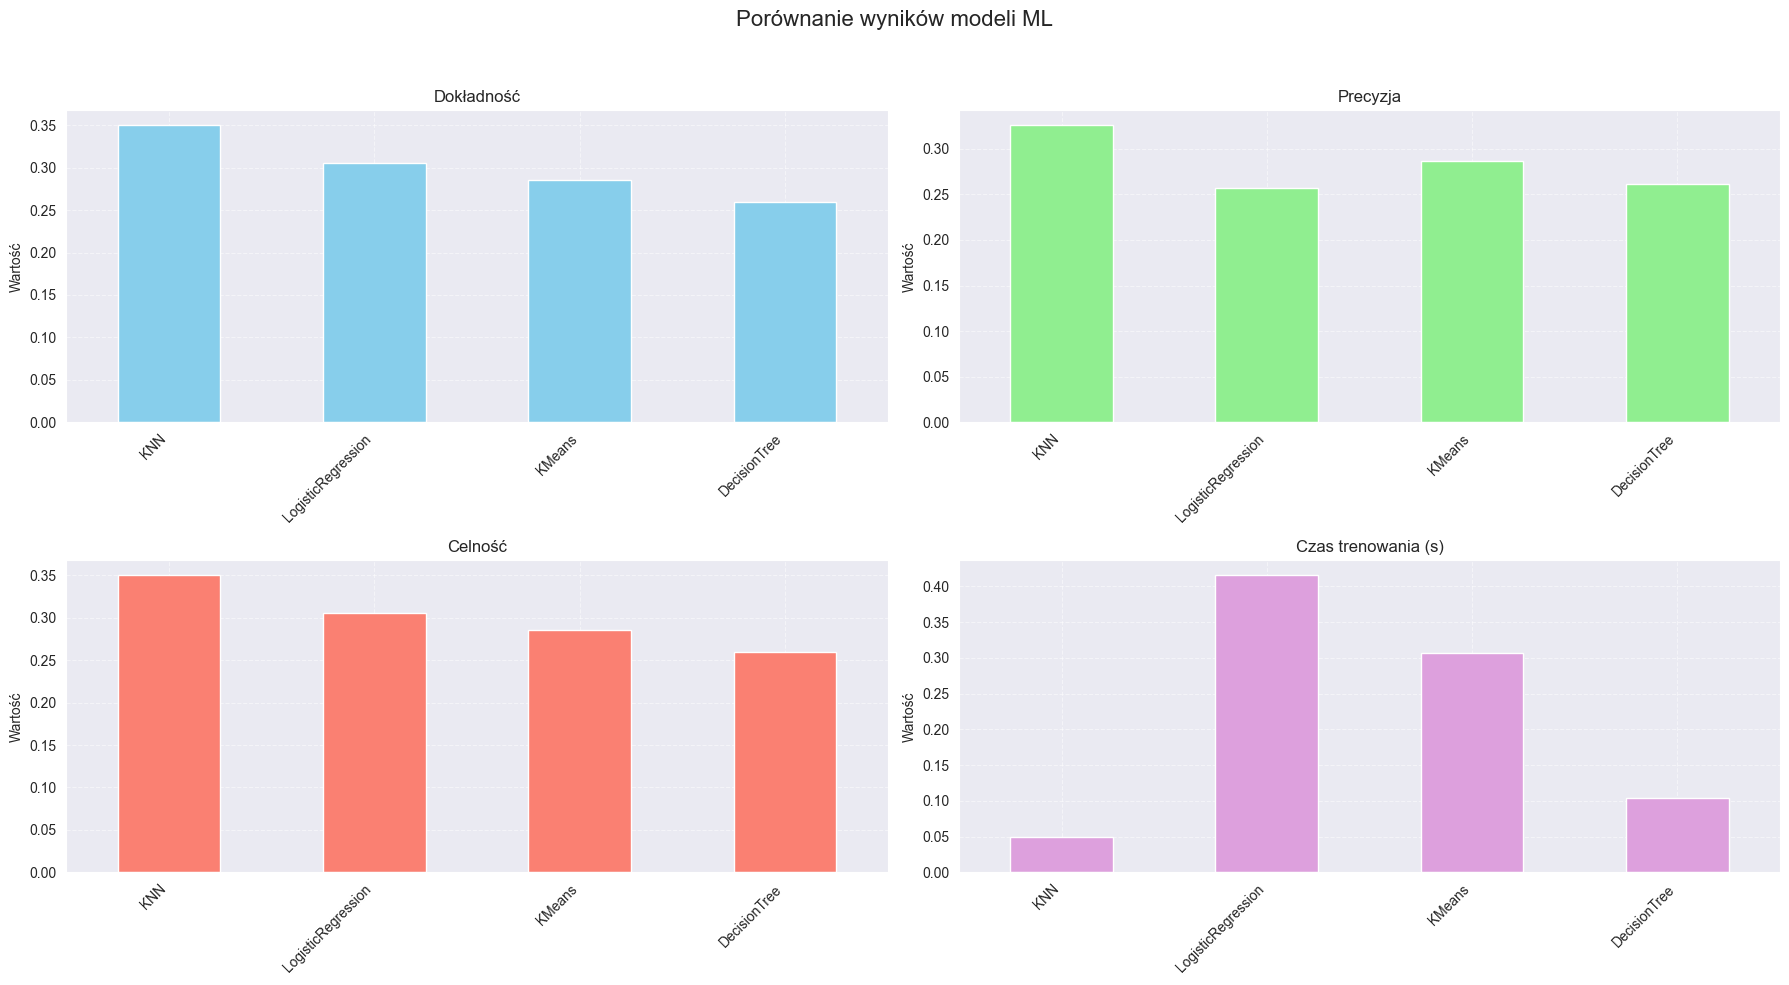

In [197]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="accuracy", ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

results_df["accuracy"].plot(kind="bar", ax=axes[0, 0], title="Dokładność", color='skyblue')
results_df["precision"].plot(kind="bar", ax=axes[0, 1], title="Precyzja", color='lightgreen')
results_df["recall"].plot(kind="bar", ax=axes[1, 0], title="Celność", color='salmon')
results_df["time"].plot(kind="bar", ax=axes[1, 1], title="Czas trenowania (s)", color='plum')

for ax in axes.flat:
    ax.set_ylabel("Wartość")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.suptitle("Porównanie wyników modeli ML", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

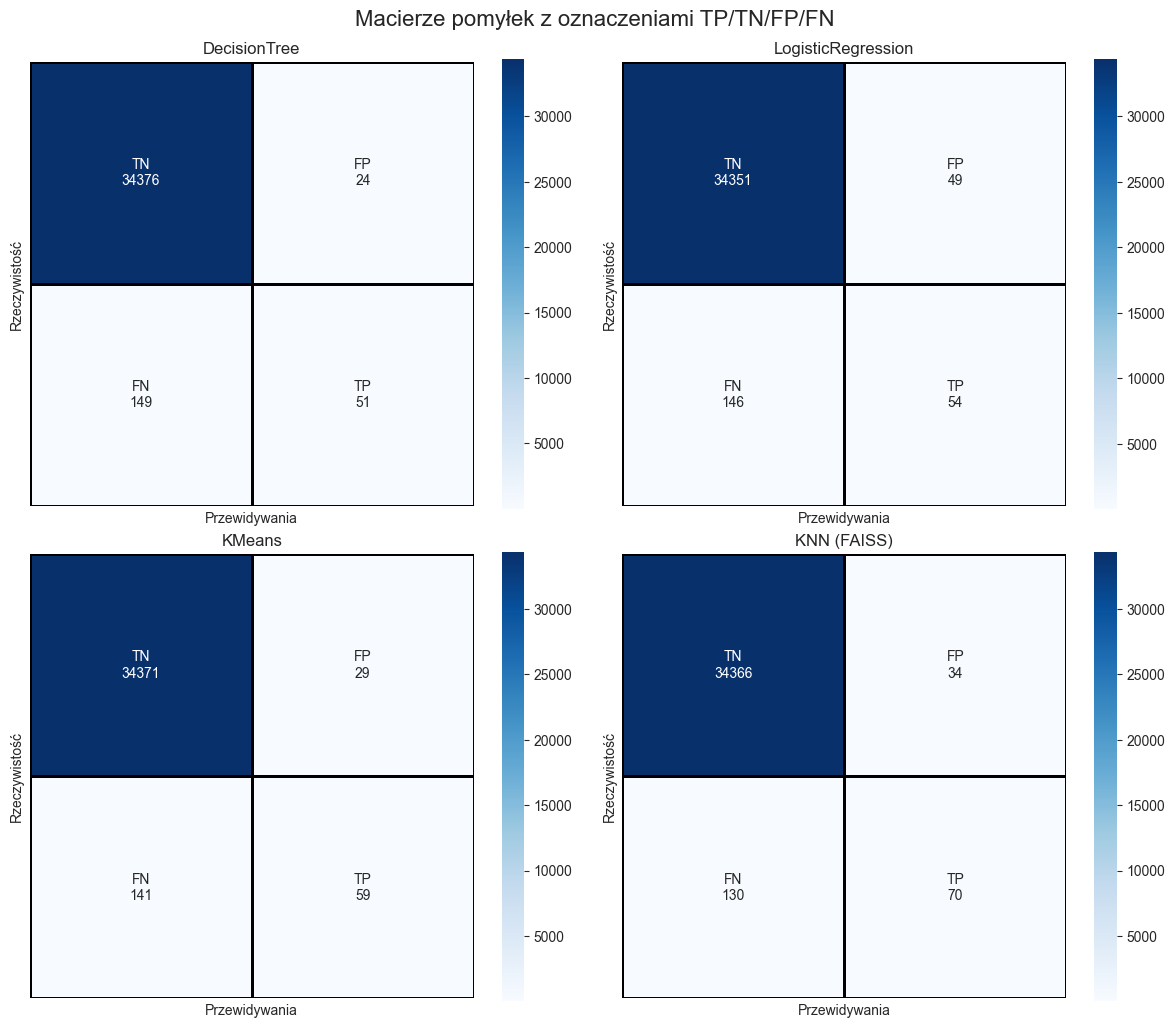

In [198]:
# Wczytywanie modeli
with open("../Models_Files/DecisionTree_model.pkl", "rb") as f:
    model_dt = pickle.load(f)
with open("../Models_Files/LogisticRegression_model.pkl", "rb") as f:
    model_lr = pickle.load(f)
with open("../Models_Files/KMeans_model.pkl", "rb") as f:
    model_kmeans = pickle.load(f)

index_faiss = faiss.read_index("../Models_Files/KNN_faiss.index")
labels_faiss = np.load("../Models_Files/KNN_labels.npy", allow_pickle=True)

# Przygotowanie danych testowych
X_test_np = np.array(X_test).astype('float32')

# Binarizer
lb = LabelBinarizer()
Y_test_bin = lb.fit_transform(Y_test)

# Przewidywania
preds = {}

# DecisionTree
y_pred_dt = model_dt.predict(X_test)
preds["DecisionTree"] = y_pred_dt

# LogisticRegression
y_pred_lr = model_lr.predict(X_test)
preds["LogisticRegression"] = y_pred_lr

# KMeans
train_clusters = model_kmeans.predict(X_train)
cluster_to_label = {}
for i in range(model_kmeans.n_clusters):
    labels_in_cluster = Y_train[train_clusters == i]
    if len(labels_in_cluster) > 0:
        cluster_to_label[i] = Counter(labels_in_cluster).most_common(1)[0][0]
    else:
        cluster_to_label[i] = "unknown"

test_clusters = model_kmeans.predict(X_test)
y_pred_kmeans = [cluster_to_label.get(c, "unknown") for c in test_clusters]
preds["KMeans"] = y_pred_kmeans

# FAISS (KNN)
_, indexes = index_faiss.search(X_test_np, k=3)
y_pred_knn = []
for neighbors in indexes:
    neighbor_labels = labels_faiss[neighbors]
    most_common = Counter(neighbor_labels).most_common(1)[0][0]
    y_pred_knn.append(most_common)
preds["KNN (FAISS)"] = y_pred_knn

# Rysowanie macierzy pomyłek z oznaczeniami TP, TN, FP, FN w środku
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (model_name, y_pred) in enumerate(preds.items()):
    y_pred_bin = lb.transform(y_pred)
    total_cm = np.zeros((2, 2), dtype=int)

    for j in range(Y_test_bin.shape[1]):
        cm = confusion_matrix(Y_test_bin[:, j], y_pred_bin[:, j])
        if cm.shape == (2, 2):
            total_cm += cm

    # Etykiety TP, TN, FP, FN
    cell_labels = np.array([["TN", "FP"], ["FN", "TP"]])
    annot = np.empty_like(total_cm).astype(str)
    for r in range(2):
        for c in range(2):
            annot[r, c] = f"{cell_labels[r, c]}\n{total_cm[r, c]}"

    sns.heatmap(total_cm, annot=annot, fmt='', cmap="Blues",
                linewidths=1, linecolor='black', square=True, ax=axes[i])
    axes[i].set_title(model_name)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("Przewidywania")
    axes[i].set_ylabel("Rzeczywistość")

plt.tight_layout()
plt.suptitle("Macierze pomyłek z oznaczeniami TP/TN/FP/FN", fontsize=16, y=1.02)
plt.show()